# Kalman Filtering and Smoothing

__Overview__: This lab is meant as an introduction to latent dynamical systems and Kalman filtering.

__Goals__: Students should:

1. Be able to implement Kalman filtering.
2. Gain intuition for how different assumptions about the parameters change the distribution of the latent space.

In [1]:
from typing import Any, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def plot_means_and_cov(means: np.ndarray, covariances: np.ndarray, ax: Any, color: str, label: str):
    """Plot the mean and covariance of our filtering/smoothing.

    Args:
        means: Means to plot.
        covariances: Covariances to plot.
        ax: Axis on which to plot.
        color: Color for plotting.
        label: Label for plotted points.

    Notes:
        Will plot the 68% contours from the covariances.
    """
    # Plot the trend line.
    ax.plot(means[:,0], means[:,1], '-', color=color, label=label)

    # Plot the ellipses for covariances. Assume they are diagonal (true for this lab).
    for i in range(len(means)):
        elip = Ellipse((means[i,0], means[i,1]), np.sqrt(covariances[i,0,0]), np.sqrt(covariances[i,1,1]), color=color, alpha=0.1)
        ax.add_patch(elip)

def plot_true_path(time: np.ndarray, ax: Any):
    """Plot the true trajectory to compare to the latent space.

    Args:
        time: Times at which to plot the true trajectory
        ax: Axis on which to plot.
    """
    v_true = 10.0
    theta_true = np.pi / 3
    x_true = np.cos(theta_true) * v_true * time
    y_true = np.sin(theta_true) * v_true * time - 0.5 * 10.0 * time ** 2

    ax.plot(x_true, y_true, color='black', label='True Trajectory')
    

## Part I: Running a Kalman Filter / Smoothing Model

We will start from a pre-generated dataset for this lab. I will tell you that this data comes from a simple kinemtaics simulation that follows these equations:

$$
X_t = \left[ v \cos(\theta) t, v \sin(\theta) t + \frac{a}{2} t^2 \right] + W_t
$$

where $v$, $a$, and $\theta$ are parameters of our system and $W_t$ is a two-dimensional white-noise vector $W_t \sim \mathcal{N}(0, \sigma_w^2 \mathbb{I}$). This equation doesn't fully align with the assumptions of our LDS model, so it will be interesting to see how our model responds to the data. We will model the data as a linear dynamical system like the one we introduced in this week's lecture. Our latent space is the true position of our object as a function of time, and our observations are the noisy readout of those true positions.

In the future, we will discuss how to learn the parameters of our model from the data, but for now let's just make reasonable choices for our parameters and conduct our filtering from there. Let's start with our equations:

$$
\mathbf{z}_t = \mathbf{A} \mathbf{z}_{t-1} + \mathbf{w}_t
$$
$$
\mathbf{x}_t = \mathbf{C} \mathbf{z}_{t} + \mathbf{v}_t,
$$

and set $\mathbf{w}_t \sim \mathcal{N}(0,\sigma_w^2 \mathbb{I})$,  $\mathbf{v}_t \sim \mathcal{N}(0,\sigma_v^2 \mathbb{I})$,  $A = a \mathbb{I}$, and $C = c \mathbb{I}$. We will pick different values of $\sigma_w, \sigma_v, a, c$ throughout the lab. Notice that we are assuming the same dimension for the latent and observation space in this model.

Let's start by implementing a class that can conduct the Kalman filtering and smoothing steps for our model. Assume that our initial state is determined by:
$$
\mathbf{z}_0 \sim \mathcal{N}(\mu_0, \sigma_{w,0}^2 \mathbb{I}).
$$

In [11]:
class KalmanFilter:
    """Class that implements the Kalman Filter for our LDS model.

    Args:
        sigma_w: Standard deviation of latent space noise.
        sigma_v: Standard deviation of observation noise.
        a: Magnitude of latent space transition matrix.
        c: Magnitude of the observation matrix.
        dim_z: Dimension of latent space.
        dim_x: Dimension of observation space.
        sigma_w_zero: Initial standard deviation of the zero state.
        mu_zero: Initial mean of the zero state.
    """
    def __init__(self, sigma_w: float, sigma_v: float, a: float, c: float, dim_z: int, 
                 dim_x: int, sigma_w_zero: float, mu_zero: np.ndarray):
        """Initialize our class."""
        # Save a few variables for bookkeeping
        self.dim_x = dim_x
        self.dim_z = dim_z
        
        # TODO: Implement the transition, observation, and noise covariance matrices.
        self.transition_matrix = a * np.eye(dim_z)  # A 
        self.observation_matrix = c * np.eye(dim_x, dim_z)  # C 
        self.transition_covariance = (sigma_w ** 2) * np.eye(dim_z)  # Q 
        self.observation_covariance = (sigma_v ** 2) * np.eye(dim_x)  # R 


        # TODO: Implement the initial covariance and mean of the zero state.
        self.mu_zero = mu_zero # TODO
        self.cov_zero = (sigma_w_zero ** 2) * np.eye(dim_z) # TODO
        
    def filter(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate the filtered mean and covariances of the latent space.

        Args:
            data: Observations with shape [n_observations, dim_x]

        Returns:
            Filtered mean and covariance for the latent space. The first dimension
            of both should be n_observations+1 since the initial latent state has no
            paired observation.
        """
        
        # Make sure the dimensions match and create some placeholders for the outputs.
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x
        filtered_means = np.zeros((n_observations + 1, self.dim_z))
        filtered_covs = np.zeros((n_observations + 1, self.dim_z, self.dim_z))
        
        # TODO: Implement filtering.
        # Initialize the zero state
        filtered_means[0] = self.mu_zero
        filtered_covs[0] = self.cov_zero

        for t in range(n_observations):
            # Prediction step
            pred_mean = self.transition_matrix @ filtered_means[t] # μ_t|t-1 = A * μ_{t-1|t-1} 
            pred_cov = self.transition_matrix @ filtered_covs[t] @ self.transition_matrix.T + self.transition_covariance # Σ_t|t-1 = A * Σ_{t-1|t-1} * A^T + Q
            
            # Kalman Gain
            # K_t = Σ_t|t-1 * C^T * (C * Σ_t|t-1 * C^T + R)^(-1)
            S = self.observation_matrix @ pred_cov @ self.observation_matrix.T + self.observation_covariance 
            K = pred_cov @ self.observation_matrix.T @ np.linalg.inv(S)

            # Update Step
            filtered_means[t + 1] = pred_mean + K @ (data[t] - self.observation_matrix @ pred_mean) # μ_t|t = μ_t|t-1 + K_t * (x_t - C * μ_t|t-1)
            filtered_covs[t + 1] = pred_cov - K @ self.observation_matrix @ pred_cov # Σ_t|t = Σ_t|t-1 - K_t * C * Σ_t|t-1
        
        return filtered_means, filtered_covs


    def smooth(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate the smoothed mean and covariances of the latent space.

        Args:
            data: Observations with shape [n_observations, dim_x]

        Returns:
            Smoothed mean and covariance for the latent space. The first dimension
            of both should be n_observations+1 since the initial latent state has no
            paired observation.        
        """
        # Validate the data dimensions.
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x
        
        # Run the forward path
        filtered_means, filtered_covs = self.filter(data)
        
        # Create holders for outputs
        smoothed_means = np.zeros((n_observations + 1, self.dim_z))
        smoothed_covs = np.zeros((n_observations + 1, self.dim_z, self.dim_z))
        
        # TODO: Implement smoothing.    
        # Initialize with the filtered results
        smoothed_means[-1] = filtered_means[-1]
        smoothed_covs[-1] = filtered_covs[-1]
        
        # Backward smoothing
        for t in reversed(range(n_observations)):
            # F_t = Σ_t|t A^T (Σ_{t+1|t})^{-1}
            pred_cov = self.transition_matrix @ filtered_covs[t] @ self.transition_matrix.T + self.transition_covariance 
            gain = filtered_covs[t] @ self.transition_matrix.T @ np.linalg.inv(pred_cov) 
            
            smoothed_means[t] = filtered_means[t] + gain @ (smoothed_means[t + 1] - self.transition_matrix @ filtered_means[t]) # μ_t|T = μ_t|t + F_t * (μ_{t+1|T} - μ_{t+1|t})
            smoothed_covs[t] = filtered_covs[t] + gain @ (smoothed_covs[t + 1] - pred_cov) @ gain.T # Σ_t|T = Σ_t|t + F_t * (Σ_{t+1|T} - Σ_{t+1|t}) * F_t^T
        
        return smoothed_means, smoothed_covs


In [10]:
# Let's quickly check our values match.
kf_test = KalmanFilter(sigma_w=1.1, sigma_v=1.4, a=0.2, c=1.0, dim_z=2, dim_x=2, 
                       sigma_w_zero=1.8, mu_zero=np.array([0.2, 2.0]))

filt_mean_test, filt_cov_test = kf_test.filter(np.array([[0.1, 0.2],[0.3,0.4]]))
mean_expected = np.array([[0.2, 2.0], [0.064359, 0.318802],[0.124235, 0.194171]])
cov_expected = np.array([[[3.24, 0.0], [0.0, 3.24]],
                         [[0.79573767, 0.0],[0.0, 0.79573767]],
                         [[0.76018596, 0.0],[0.0, 0.76018596]]])
np.testing.assert_array_almost_equal(filt_mean_test, mean_expected) 
np.testing.assert_array_almost_equal(filt_cov_test, cov_expected) 

smooth_mean_test, smooth_cov_test = kf_test.smooth(np.array([[0.1, 0.2],[0.3,0.4]]))
mean_expected = np.array([[0.218687, 1.968807], [0.078631, 0.335515], [0.124235, 0.194171]])
cov_expected = np.array([[[3.11088996, 0.0],
                          [0.0, 3.11088996]],
                         [[0.78782721, 0.0],
                          [0.0, 0.78782721]],
                         [[0.76018596, 0.0],
                          [0.0, 0.76018596]]])
np.testing.assert_array_almost_equal(smooth_mean_test, mean_expected) 
np.testing.assert_array_almost_equal(smooth_cov_test, cov_expected) 

Now we can load our data and see what the results of our filtering and smoothing operations are. Let's start with the simplest choice for the parameters of our model:
$$ \sigma_w = 1.0, \sigma_v = 1.0, a=1.0, c=1.0, \sigma_{w,0} = 1.0, \mu_{0} = [0.0,0.0]
$$

You will have to
* Conduct Kalman filtering to get the Kalman filtering means and covariances and plot their values.
* Conduct Kalman smoothing to get the Kalman smoothing means and covariances and plot their values.

In [12]:
# TODO: Load the data.
import pandas as pd
import pandas as pd
data = pd.read_csv('kinematic_data.csv') # TODO
x_data = data['x_data'].values # TODO
y_data = data['y_data'].values # TODO
time = data['time'].values # TODO

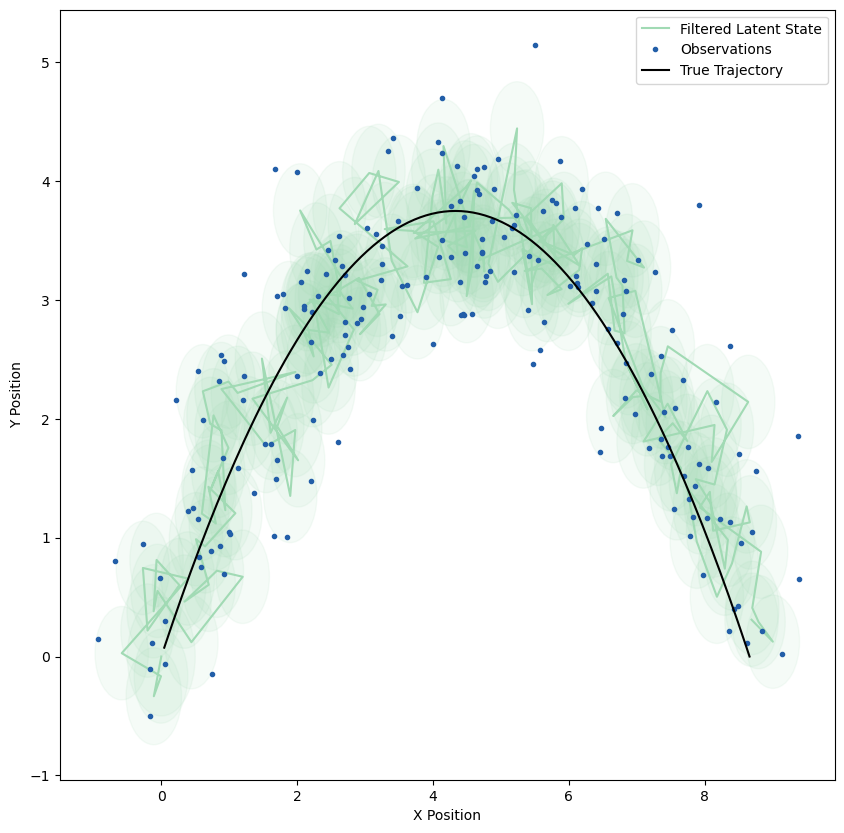

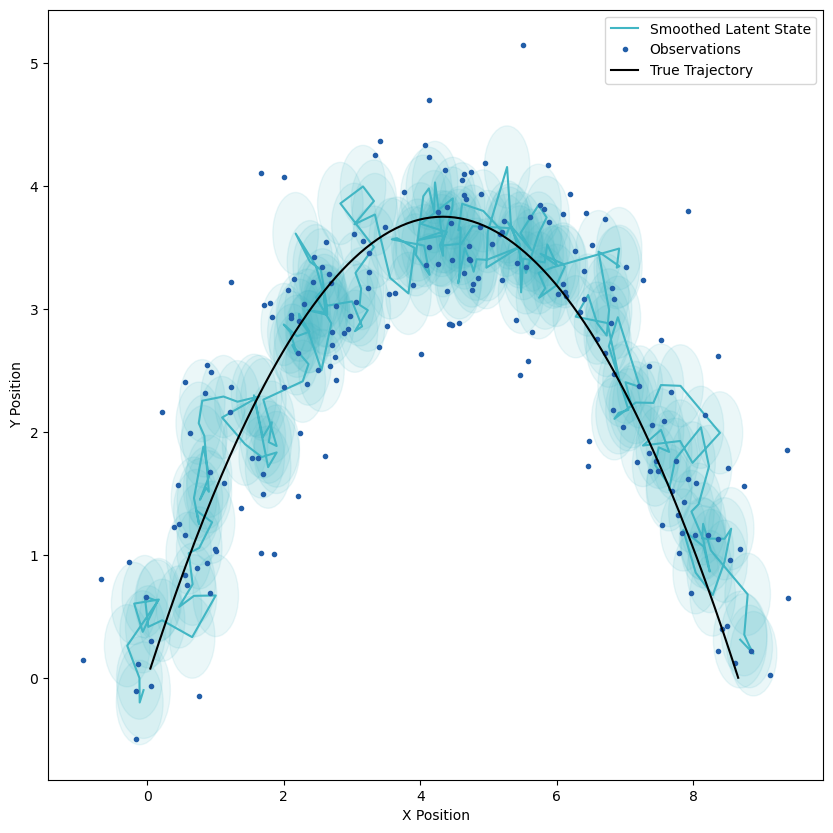

In [13]:
# TODO: Conduct Kalman filtering
data_stack = np.vstack([x_data, y_data]).T # TODO - check the args of the class you wrote.
kalman_filter = KalmanFilter(sigma_w=1.0, sigma_v=1.0, a=1.0, c=1.0, dim_z=2, dim_x=2, sigma_w_zero=1.0, mu_zero=np.array([0.0, 0.0])) # TODO
filtered_mean, filtered_covariances = kalman_filter.filter(data_stack) # TODO

# Now let the visualization tools show you what you have.
colors = ['#a1dab4','#41b6c4','#225ea8']
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
plot_means_and_cov(filtered_mean, filtered_covariances, ax, color=colors[0], label='Filtered Latent State')
ax.plot(x_data, y_data, '.', color=colors[2], label='Observations')
plot_true_path(time, ax)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

# TODO: Conduct Kalman smoothing
smooth_mean, smooth_covariances = kalman_filter.smooth(data_stack) # TODO

# Now let the visualization tools show you what you have.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
plot_means_and_cov(smooth_mean, smooth_covariances, ax, color=colors[1], label='Smoothed Latent State')
ax.plot(x_data, y_data, '.', color=colors[2], label='Observations')
plot_true_path(time, ax)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

Do you notice any difference between the smoothing and filtering distributions? What is the intuition for the difference?

# I noticed that trajectory and covariance in smoothed algorithm is slightly closer to the true trajectory.

# This is because filtering is a step-by-step process that only looks into past and current data points, while smooth algorithm uses both past and future information. Kalman Smoothing reduces the impact of noisy observations (because future steps might indicate true path), resulting in a prediction trajectory closer to true path.

## Part II: Understanding our Parameters

Next week we will learn the parameters of our LDS from the data, but this week let's build some intution. Let's start with the noise on our observations $\sigma_v$. Repeat the fitting / smoothing calculations like before, but with $\sigma_v=0.1$.

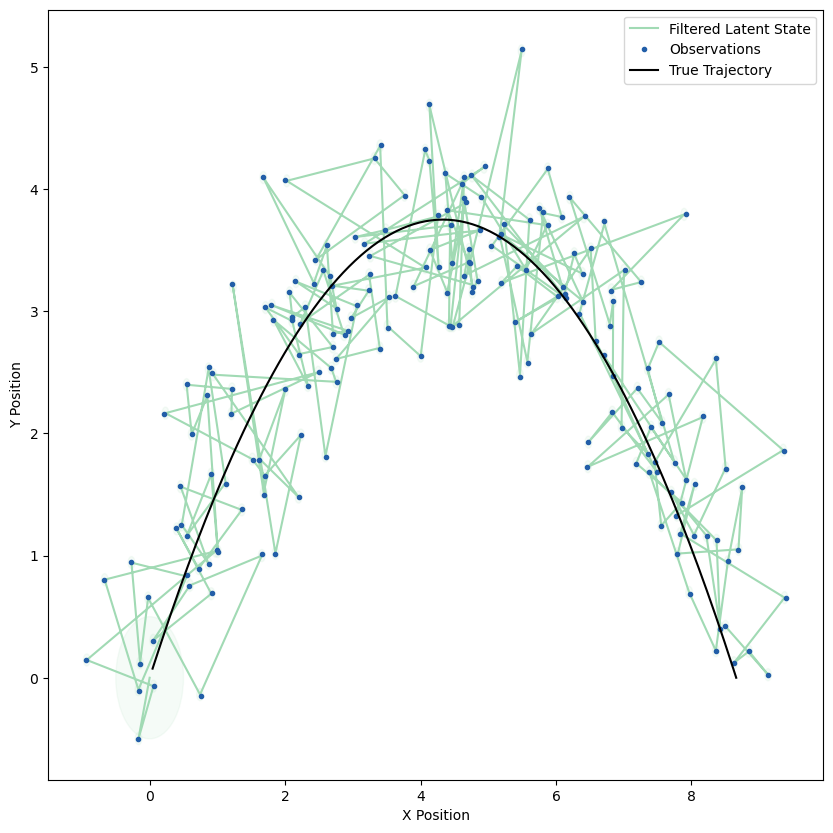

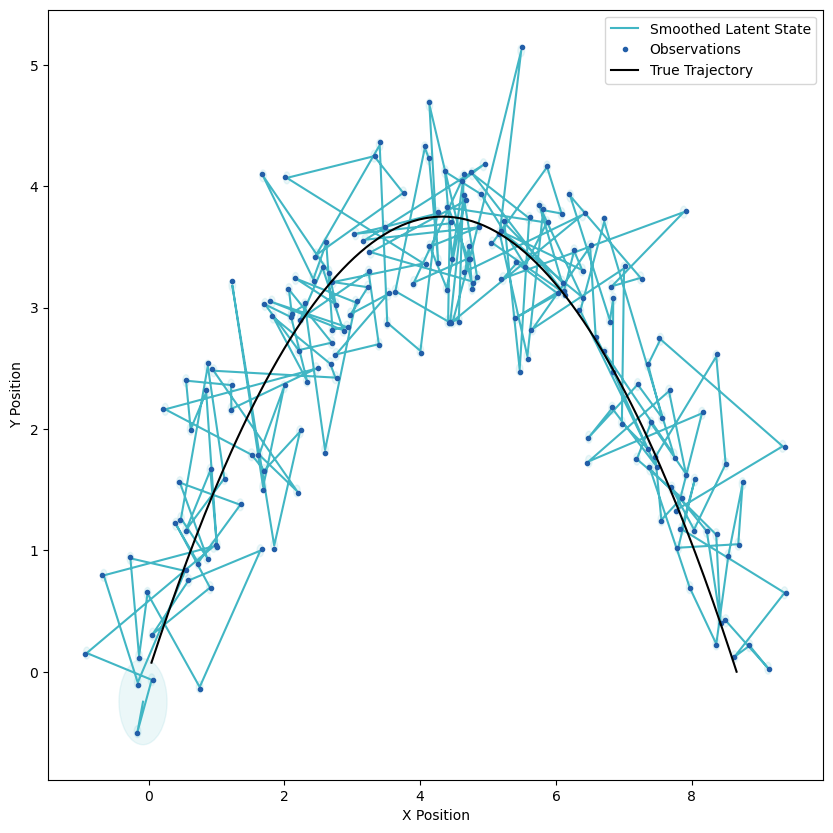

In [14]:
# TODO: Conduct Kalman filtering
kalman_filter = KalmanFilter(sigma_w=1.0, sigma_v=0.1, a=1.0, c=1.0, dim_z=2, dim_x=2, sigma_w_zero=1.0, mu_zero=np.array([0.0, 0.0])) # TODO
filtered_mean, filtered_covariances = kalman_filter.filter(data_stack) # TODO

# Now let the visualization tools show you what you have.
colors = ['#a1dab4','#41b6c4','#225ea8']
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
plot_means_and_cov(filtered_mean, filtered_covariances, ax, color=colors[0], label='Filtered Latent State')
ax.plot(x_data, y_data, '.', color=colors[2], label='Observations')
plot_true_path(time, ax)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

# TODO: Conduct Kalman smoothing
smooth_mean, smooth_covariances = kalman_filter.smooth(data_stack) # TODO

# Now let the visualization tools show you what you have.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
plot_means_and_cov(smooth_mean, smooth_covariances, ax, color=colors[1], label='Smoothed Latent State')
ax.plot(x_data, y_data, '.', color=colors[2], label='Observations')
plot_true_path(time, ax)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

How are the filtering and smoothing distributions behaving? Does this make sense given the parameters we changed?

# Since the observation noise is decreased to 0.1, our model relates more on observations. Thus we see on both filtering and smoothing plots that latent states almost align with observed points and are further around true path with higher variability. The above plot is what we expected given an observation noise close to zero.

Okay, you're probably convinced that the noise in the observation isn't small. But what about the latent space? Let's try $\sigma_w = 0.1$ and see how that changes our results.

__Don't forget to change $\sigma_v$ back__

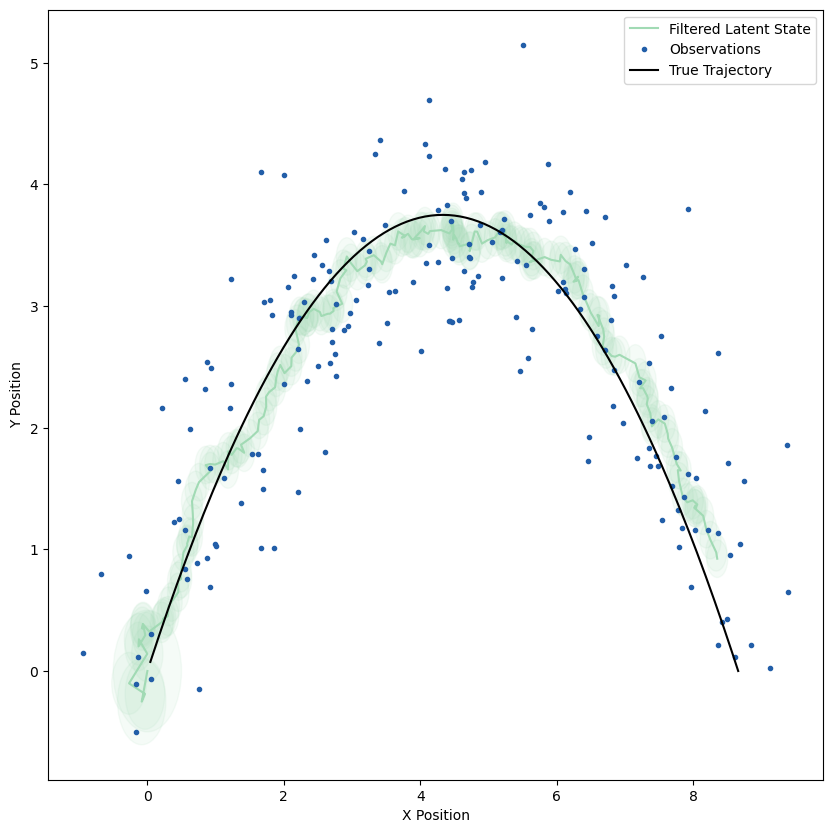

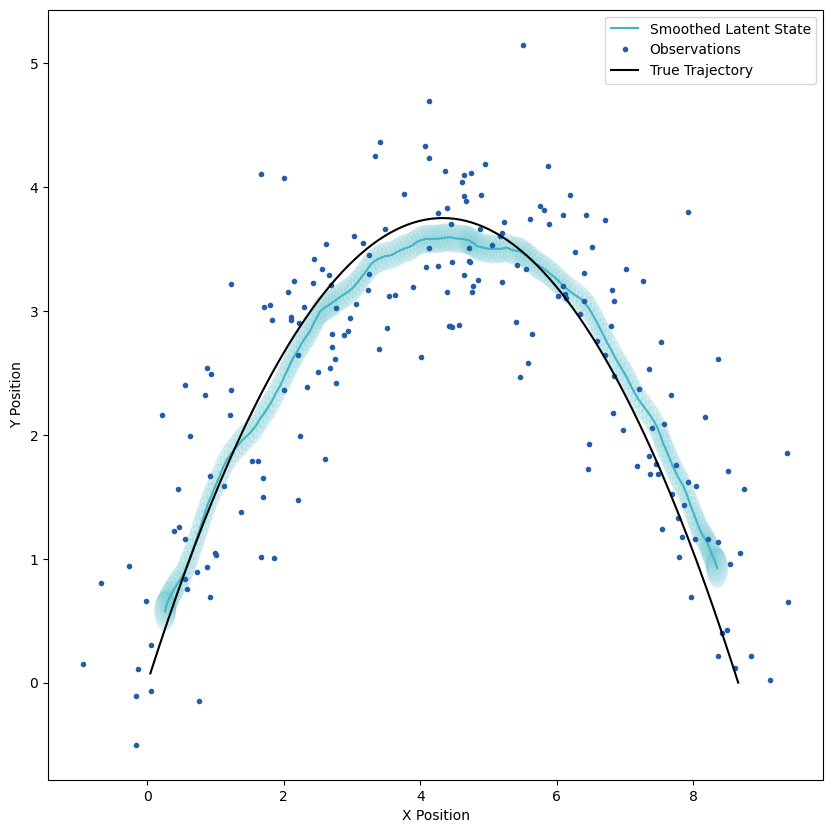

In [15]:
# TODO: Conduct Kalman filtering
kalman_filter = KalmanFilter(sigma_w=0.1, sigma_v=1.0, a=1.0, c=1.0, dim_z=2, dim_x=2, sigma_w_zero=1.0, mu_zero=np.array([0.0, 0.0])) 
filtered_mean, filtered_covariances = kalman_filter.filter(data_stack) # TODO

# Now let the visualization tools show you what you have.
colors = ['#a1dab4','#41b6c4','#225ea8']
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
plot_means_and_cov(filtered_mean, filtered_covariances, ax, color=colors[0], label='Filtered Latent State')
ax.plot(x_data, y_data, '.', color=colors[2], label='Observations')
plot_true_path(time, ax)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

# TODO: Conduct Kalman smoothing
smooth_mean, smooth_covariances = kalman_filter.smooth(data_stack) # TODO

# Now let the visualization tools show you what you have.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
plot_means_and_cov(smooth_mean, smooth_covariances, ax, color=colors[1], label='Smoothed Latent State')
ax.plot(x_data, y_data, '.', color=colors[2], label='Observations')
plot_true_path(time, ax)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

How do the smoothing and filtering distribution compare to the high $\sigma_w$ case? What is the intuition behind this?

What about the uncertanties of the filtering and smoothing distirbution? Which has larger covariances matrix values? What is the intuition behind this?

# Both curves aligns better to the true path and are much smoother. This is because the reduced process noise allows less variability between steps. With a small $\sigma_w$, the model assumes that the latent state changes smoothly, so it trusts the transitions more and needs less correction from the observations. This leads to a much smoother path with fewer deviations from the true path.The models are more confident about the latent state transitions and pay less attention to the observation noise.
# Both filtering and smoothing show smaller uncertanties in distribution compared to a larger $\sigma_w$ case. The covariance matrices which represent uncertainty grow larger when there is more noise in the system. When $\sigma_w$ is low, the latent state transitions are more predictable, and the system's overall uncertainty decreases.

One final test, let's keep $\sigma_w=0.3$ since that worked well, but start with a really bad initial guess for the latent space:
$$\mu_0 = [-2.0, 5.0].$$

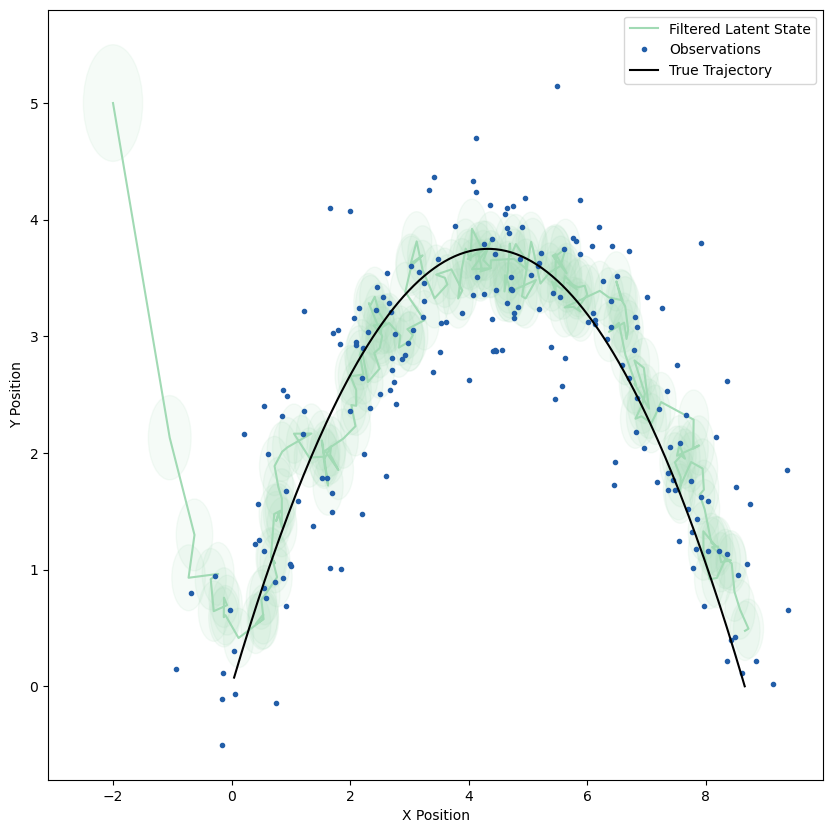

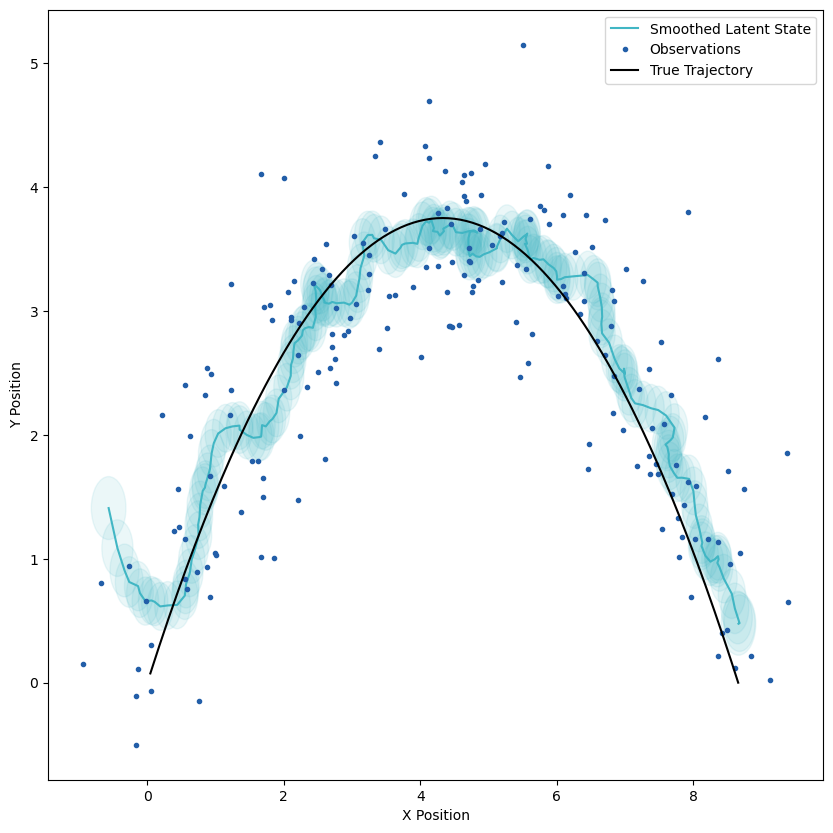

In [16]:
# TODO: Conduct Kalman filtering
kalman_filter = KalmanFilter(sigma_w=0.3, sigma_v=1.0, a=1.0, c=1.0, dim_z=2, dim_x=2, sigma_w_zero=1.0, mu_zero=np.array([-2.0, 5.0])) # TODO
filtered_mean, filtered_covariances = kalman_filter.filter(data_stack) # TODO

# Now let the visualization tools show you what you have.
colors = ['#a1dab4','#41b6c4','#225ea8']
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
plot_means_and_cov(filtered_mean, filtered_covariances, ax, color=colors[0], label='Filtered Latent State')
ax.plot(x_data, y_data, '.', color=colors[2], label='Observations')
plot_true_path(time, ax)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

# TODO: Conduct Kalman smoothing
smooth_mean, smooth_covariances = kalman_filter.smooth(data_stack) # TODO

# Now let the visualization tools show you what you have.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
plot_means_and_cov(smooth_mean, smooth_covariances, ax, color=colors[1], label='Smoothed Latent State')
ax.plot(x_data, y_data, '.', color=colors[2], label='Observations')
plot_true_path(time, ax)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

Do our filtering and smoothing distribution recover from the bad initial guess? Which set of distributions is more sensitive to the intial guess?

# Both filtering and smoothing distribution recover from the bad initial guess. In this case, filtering distribution is more sensitive to the initial guess and recovers slower.